### Installing needed libraries

In [1]:
!pip install tensorflow==2.15 tensorflow-hub==0.16.1 opencv-python

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtype

# importing needed libraries

In [39]:
# importing needed libraries
import cv2
import math
import numpy as np
import pandas as pd
from google.colab import drive
import os
import random
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, BatchNormalization, Dense, Flatten, Dropout, Activation
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import time
random.seed(24)

# connecting to google drive to get the data

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preperation: Retreiving Anomaly from google drive





In [4]:
def get_file_paths(directory):
    """Returns a list of full file paths for a given directory."""
    return [os.path.join(directory, file) for file in os.listdir(directory)]

# Base directory for video data
base_dir = "/content/drive/MyDrive/all files/Video Data"

# Anomaly video categories and their respective subdirectories
anomaly_categories = {
    "Assault": "Anomaly-Videos-Part-1/Assault",
    "Arson" : "Anomaly-Videos-Part-1/Arson",
    "Fighting": "Anomaly-Videos-Part-2/Fighting",
    "Explosion" : "Anomaly-Videos-Part-2/Explosion"
    # "Robbery": "Anomaly-Videos-Part-3/Robbery"
}

# Collect anomaly video paths
anomaly_videos = {category: get_file_paths(os.path.join(base_dir, path)) for category, path in anomaly_categories.items()}
anomaly_frames = base_dir + "/Temporal_Anomaly_Annotation_for_Testing_Videos (1).txt"

In [5]:
print(len(anomaly_videos['Assault']))
print(len(anomaly_videos['Fighting']))
print(len(anomaly_videos['Explosion']))
print(len(anomaly_videos['Arson']))

50
50
50
50


# Getting Anomaly types Frames

In [6]:
anomaly_frame_dict = {}
with open(anomaly_frames, 'r') as file:
  for line in file:
    line_split = line.split()
    if len(line_split) >= 4:  # Ensure there are enough elements in the line
      video_name = line_split[0]
      if video_name not in anomaly_frame_dict:  # Check if the video is already processed
        # Attempt to convert frame indices to integers and store
        try:
          start_frame = int(line_split[2])
          end_frame = int(line_split[3])
          anomaly_frame_dict[video_name] = (start_frame, end_frame)
          print(f"{video_name}: {anomaly_frame_dict[video_name]}")  # Optional: print for debugging
        except ValueError:
          print(f"Warning: Non-integer frame indices found in line: {line}")
    else:
      print(f"Warning: Insufficient data in line: {line}")

Abuse001_x264.mp4: (210, 350)
Abuse002_x264.mp4: (0, 180)
Abuse003_x264.mp4: (900, 1170)
Abuse004_x264.mp4: (780, 1000)
Abuse005_x264.mp4: (660, 860)
Abuse006_x264.mp4: (300, 510)
Abuse007_x264.mp4: (0, 150)
Abuse008_x264.mp4: (4440, 4590)
Abuse009_x264.mp4: (240, 570)
Abuse010_x264.mp4: (0, 300)
Abuse011_x264.mp4: (300, 600)
Abuse012_x264.mp4: (300, 450)
Abuse013_x264.mp4: (0, 300)
Abuse014_x264.mp4: (1260, 1410)
Abuse015_x264.mp4: (2850, 3000)
Abuse016_x264.mp4: (750, 1080)
Abuse017_x264.mp4: (240, 370)
Abuse018_x264.mp4: (1620, 1740)
Abuse019_x264.mp4: (2100, 2550)
Abuse020_x264.mp4: (1620, 1740)
Abuse021_x264.mp4: (1200, 2550)
Abuse022_x264.mp4: (120, 300)
Abuse023_x264.mp4: (0, 180)
Abuse024_x264.mp4: (570, 700)
Abuse025_x264.mp4: (420, 550)
Abuse026_x264.mp4: (140, 300)
Abuse027_x264.mp4: (1710, 2100)
Abuse028_x264.mp4: (165, 240)
Abuse030_x264.mp4: (1275, 1360)
Abuse031_x264.mp4: (3780, 4200)
Abuse032_x264.mp4: (540, 990)
Abuse033_x264.mp4: (1200, 1350)
Abuse035_x264.mp4: (0, 30

In [7]:
paths = []
for item in anomaly_videos:
  for video in anomaly_videos[item]:
    path = video.split("/")[-1]
    paths.append(path)
frames_range = []
for item in anomaly_frame_dict.keys():
  if item in paths:
    print(item)
    print(anomaly_frame_dict[item])
    sub = anomaly_frame_dict[item][1]-anomaly_frame_dict[item][0]
    print(sub)
    frames_range.append(sub)
  else:
    print(f"video {item} not found")
anomalies_to_remove = []
for item in paths:
  if item not in anomaly_frame_dict.keys():
    anomalies_to_remove.append(item)
    print(item)

video Abuse001_x264.mp4 not found
video Abuse002_x264.mp4 not found
video Abuse003_x264.mp4 not found
video Abuse004_x264.mp4 not found
video Abuse005_x264.mp4 not found
video Abuse006_x264.mp4 not found
video Abuse007_x264.mp4 not found
video Abuse008_x264.mp4 not found
video Abuse009_x264.mp4 not found
video Abuse010_x264.mp4 not found
video Abuse011_x264.mp4 not found
video Abuse012_x264.mp4 not found
video Abuse013_x264.mp4 not found
video Abuse014_x264.mp4 not found
video Abuse015_x264.mp4 not found
video Abuse016_x264.mp4 not found
video Abuse017_x264.mp4 not found
video Abuse018_x264.mp4 not found
video Abuse019_x264.mp4 not found
video Abuse020_x264.mp4 not found
video Abuse021_x264.mp4 not found
video Abuse022_x264.mp4 not found
video Abuse023_x264.mp4 not found
video Abuse024_x264.mp4 not found
video Abuse025_x264.mp4 not found
video Abuse026_x264.mp4 not found
video Abuse027_x264.mp4 not found
video Abuse028_x264.mp4 not found
video Abuse030_x264.mp4 not found
video Abuse031

In [8]:
counter = 0
for category in anomaly_videos.keys():
  for item in anomalies_to_remove:
    for video in anomaly_videos[category]:
      if item in video:
        anomaly_videos[category].remove(video)
        counter+=1
print(counter)

4


In [9]:
total_anomaly_video_len = 0
for i in anomaly_videos.keys():
  print(f"{i}: {len(anomaly_videos[i])}")
  total_anomaly_video_len+= len(anomaly_videos[i])
print(total_anomaly_video_len)

Assault: 48
Arson: 48
Fighting: 50
Explosion: 50
196


In [10]:
print(len(frames_range))
print(f"anomaly_frames median value:{np.median(frames_range)}")
print(f"anomaly_frames mean value:{np.mean(frames_range)}")
print(f"anomaly_frames max value:{max(frames_range)}")
print(f"anomaly_frames min value:{min(frames_range)}")

196
anomaly_frames median value:270.0
anomaly_frames mean value:355.4030612244898
anomaly_frames max value:6911
anomaly_frames min value:75


# Data Preperation

In [11]:
def get_label_from_path(file_path):
  if "Assault" in file_path or "Fighting" in file_path:
    return "Violence"
  else:
    return "Explosion"


## Splitting to Train,Val and Test 80% 10% 10%

In [12]:
import math
import random

# Function to split videos into training, validation, and test sets
def split_videos(videos, train_ratio=0.8, val_ratio=0.1):
    train_size = math.ceil(len(videos) * train_ratio)
    val_size = math.ceil(len(videos) * val_ratio)
    return videos[:train_size], videos[train_size:train_size + val_size], videos[train_size + val_size:]

# Splitting the videos for each anomaly category
train_videos = {}
val_videos = {}
test_videos = {}
total_train_anomaly_size = 0
total_val_anomaly_size = 0
for category, videos in anomaly_videos.items():
    train_videos[category], val_videos[category], test_videos[category] = split_videos(videos)
    total_train_anomaly_size += len(train_videos[category])
    total_val_anomaly_size += len(val_videos[category])

# Now, train_videos, val_videos, and test_videos dictionaries hold the training, validation, and testing videos for each category respectively

# Combine all anomaly videos, then shuffle
all_anomaly = []
for category in train_videos:
    all_anomaly.extend(train_videos[category] + val_videos[category] + test_videos[category])
random.shuffle(all_anomaly)

# Calculate the total number of anomaly videos
total_anomaly_videos = len(all_anomaly)

# The anomaly videos are already combined, just split them into training, validation, and testing sets
new_train_Anomaly = all_anomaly[:total_train_anomaly_size]
new_val_Anomaly = all_anomaly[total_train_anomaly_size:total_train_anomaly_size + total_val_anomaly_size]
new_test_Anomaly = all_anomaly[total_train_anomaly_size + total_val_anomaly_size:]

# Print lengths to verify
print(f"New Train Anomaly: {len(new_train_Anomaly)} videos")
print(f"New Val Anomaly: {len(new_val_Anomaly)} videos")
print(f"New Test Anomaly: {len(new_test_Anomaly)} videos")


New Train Anomaly: 158 videos
New Val Anomaly: 20 videos
New Test Anomaly: 18 videos


In [15]:
train_file_paths = new_train_Anomaly
validation_file_paths = new_val_Anomaly
test_file_paths = new_test_Anomaly
random.shuffle(train_file_paths)
random.shuffle(validation_file_paths)
random.shuffle(test_file_paths)

In [16]:
print(len(train_file_paths))
print(len(validation_file_paths))
print(len(test_file_paths))

158
20
18


getting the corresponding labels

In [17]:
test_labels = [get_label_from_path(path) for path in test_file_paths]
validation_labels = [get_label_from_path(path) for path in validation_file_paths]
train_labels = [get_label_from_path(path) for path in train_file_paths]
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_val = label_encoder.fit_transform(validation_labels)
y_train = label_encoder.fit_transform(train_labels)
y_test = label_encoder.fit_transform(test_labels)

In [18]:
y_test

array([0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0])

In [19]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping: ", label_mapping)

Label Mapping:  {'Explosion': 0, 'Violence': 1}


## data preprocessing



**data augmentation**

In [20]:
def data_augment(frame):
    frame = tf.image.random_flip_left_right(frame)
    frame = tf.image.random_flip_up_down(frame)
    return frame


Getting the frame intervals from the previous created dictionary

In [21]:
def get_frame_intervals(video_path):
    video_path = video_path.decode("utf-8") if isinstance(video_path, bytes) else video_path
    video_name = os.path.basename(video_path)
    start_frame = None
    end_frame = None
    is_valid_frame_found = False

    # Check for anomalies
    if video_name in anomaly_frame_dict:
      start_frame, end_frame = anomaly_frame_dict[video_name]
      is_valid_frame_found = True if start_frame != -1 and end_frame != -1 else False

    return start_frame, end_frame, is_valid_frame_found

## extracting train frames

In [22]:
def extract_frames(video_path, label, resize=(224, 224), max_frames=50, augment = False):
    video_path = video_path.decode("utf-8") if isinstance(video_path, bytes) else video_path
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = 7
    augmented_frames = None
    frames = []
    if augment:
      augmented_frames = []
    empty_frame = np.zeros((resize[1], resize[0], 3))

    if video_path.split('/')[-1] in anomaly_frame_dict:
        start_frame, end_frame, is_valid_frame_found = get_frame_intervals(video_path)
        if not is_valid_frame_found or start_frame is None:
            start_frame, end_frame = 0, total_frames
    else:
        start_frame, end_frame = 0, total_frames

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    while len(frames) < max_frames and cap.get(cv2.CAP_PROP_POS_FRAMES) <= end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        if (cap.get(cv2.CAP_PROP_POS_FRAMES) - 1 - start_frame) % interval == 0:
            frame = cv2.resize(frame, resize)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
            frame = frame.astype(np.float32) / 255.0
            frames.append(frame)
    cap.release()

    if len(frames) < max_frames:
        i = 0
        while len(frames) < max_frames:
            frames.append(frames[i])
            i+=1
    if augment:
      for frame in frames:
        augmented_frames.append(data_augment(frame))

    if not augment:
      return np.array(frames, dtype=np.float32), int(label)
    else:
      return  np.array(augmented_frames, dtype=np.float32), int(label)


In [23]:
def preprocess_dataset(file_paths, labels, max_frames=50, resize=(224, 224), augment= False):
    def load_and_preprocess(video_path, label):
        frames, Original_label = tf.numpy_function(
            extract_frames,
            [video_path, label, resize, max_frames, augment],
            [tf.float32, tf.int64])  # Ensure correct data types

        num_channels = 3  # RGB channels
        frames.set_shape([max_frames, resize[1], resize[0], num_channels])
        Original_label.set_shape([])  # Single label per video

        return frames, Original_label

    path_ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    path_ds = path_ds.shuffle(buffer_size=len(file_paths), reshuffle_each_iteration=True)  # Shuffle the dataset at each epoch
    dataset = path_ds.map(lambda video_path, label: load_and_preprocess(video_path, label),
                          num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(4,drop_remainder=False).prefetch(tf.data.AUTOTUNE)



In [24]:
train_ds = preprocess_dataset(train_file_paths, y_train)
augmented_train_ds = preprocess_dataset(train_file_paths, y_train, augment = True)
# combining train dataset and the augmented dataset
train_ds_final = train_ds.concatenate(augmented_train_ds)

In [25]:
print(len(train_ds))

40


In [26]:
print(len(augmented_train_ds))

40


In [27]:
print(len(train_ds_final))

80


In [28]:
def preprocess_validation_dataset(file_paths, labels, max_frames=50, resize=(224, 224), augment=False):
    def load_and_preprocess(video_path, label):
        video, segment_labels = tf.numpy_function(
            extract_frames,
            [video_path, label, resize, max_frames, augment],
            [tf.float32, tf.int64])  # Ensure correct data types

        num_channels = 3  # RGB channels
        video.set_shape([max_frames, resize[1], resize[0], num_channels])
        segment_labels.set_shape([])  # Single label per video

        return video, segment_labels

    path_ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = path_ds.map(lambda video_path, label: load_and_preprocess(video_path, label),
                          num_parallel_calls=tf.data.AUTOTUNE)

    return dataset.batch(4,drop_remainder=False).prefetch(tf.data.AUTOTUNE)

In [29]:
val_ds = preprocess_validation_dataset(validation_file_paths, y_val)

# **defining the model**

## using I3D pretrained model -

its actually a really good pretrained 2D CNN models and "inflate" them - enlarging the pooling sizes to 3D and the conv parts to 3D


How I3D Works
Inflation: The convolutional filters and pooling operations from the original 2D network are converted to 3D by adding an additional temporal dimension. For example, a 2D convolutional filter of size
3×3 becomes a 3D filter of size
3×3×3.

Pre-training on Image Data: The network can be pre-trained on large image datasets like ImageNet using the original 2D architecture. The weights from this pre-training can then be inflated to initialize the 3D network. This step leverages the vast amount of labeled image data to provide a good starting point for training on video data.


Fine-tuning on Video Data: After inflating the network and initializing it with pre-trained weights, it is fine-tuned on video datasets to adapt to the temporal dimension.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# Number of classes
num_classes = 1
adam = Adam(learning_rate=0.0001)
# Load the I3D model from TensorFlow Hub
i3d_module = hub.KerasLayer("https://tfhub.dev/deepmind/i3d-kinetics-600/1", trainable=False)

def build_model_second():
    # Define the input shape
    inputs = tf.keras.Input(shape=(50, 224, 224, 3))  # Adjust input shape as needed

    # Apply the I3D module
    x = i3d_module(inputs)

    # Add new dense layers
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(32, activation='tanh')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Compile the model
second_model = build_model_second()
second_model.compile(optimizer= adam, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

second_model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 50, 224, 224, 3   0         
                             )]                                  
                                                                 
 keras_layer_4 (KerasLayer)  (None, 600)               12909544  
                                                                 
 dense_12 (Dense)            (None, 128)               76928     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 32)                4128      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                           

In [ ]:
class PlotAndSaveLearning(Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {'epoch': [], 'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

    def on_epoch_end(self, epoch, logs={}, checkpoint='/content/drive/My Drive/all files/Model_Metrics'):
        # Append the current epoch's metrics
        self.metrics['epoch'].append(epoch)
        self.metrics['accuracy'].append(logs.get('accuracy'))
        self.metrics['val_accuracy'].append(logs.get('val_accuracy'))
        self.metrics['loss'].append(logs.get('loss'))
        self.metrics['val_loss'].append(logs.get('val_loss'))

        # Save the metrics to a CSV file
        df = pd.DataFrame(self.metrics)
        df.to_csv(f'{checkpoint}/"second_model_epoch_metrics_03_07_1.csv', index=False)

        # Plotting the metrics
        plt.figure(figsize=(12, 6))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(df['accuracy'], label='Train Accuracy')
        plt.plot(df['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(df['loss'], label='Train Loss')
        plt.plot(df['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()

# Callbacks
checkpoint_path = '/content/drive/My Drive/all files/second_model03.07.2024-1.h5'  # Update the path as needed
plot_and_save_learning = PlotAndSaveLearning()
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=3, min_lr=0.000001)
callbacks = [model_checkpoint, early_stopping, plot_and_save_learning, reduce_lr]

## model training

Epoch 1/100
80/80 [==============================] - ETA: 0s - loss: 0.8224 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 0.66017, saving model to /content/drive/My Drive/all files/second_model03.07.2024-1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


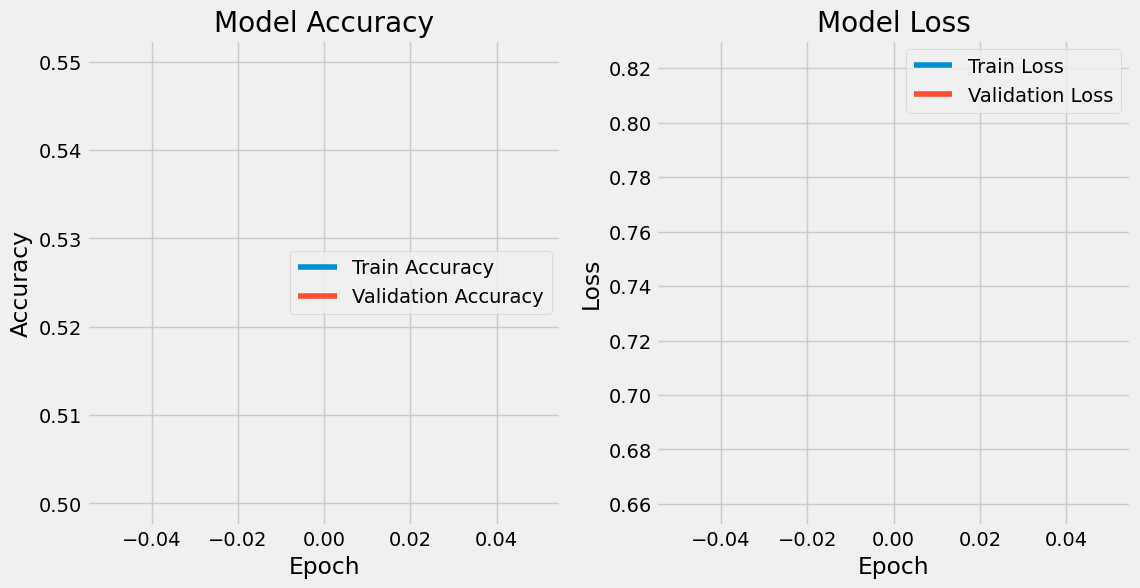

80/80 [==============================] - 60s 696ms/step - loss: 0.8224 - accuracy: 0.5000 - val_loss: 0.6602 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 2/100
80/80 [==============================] - ETA: 0s - loss: 0.7018 - accuracy: 0.5854
Epoch 2: val_loss improved from 0.66017 to 0.65059, saving model to /content/drive/My Drive/all files/second_model03.07.2024-1.h5


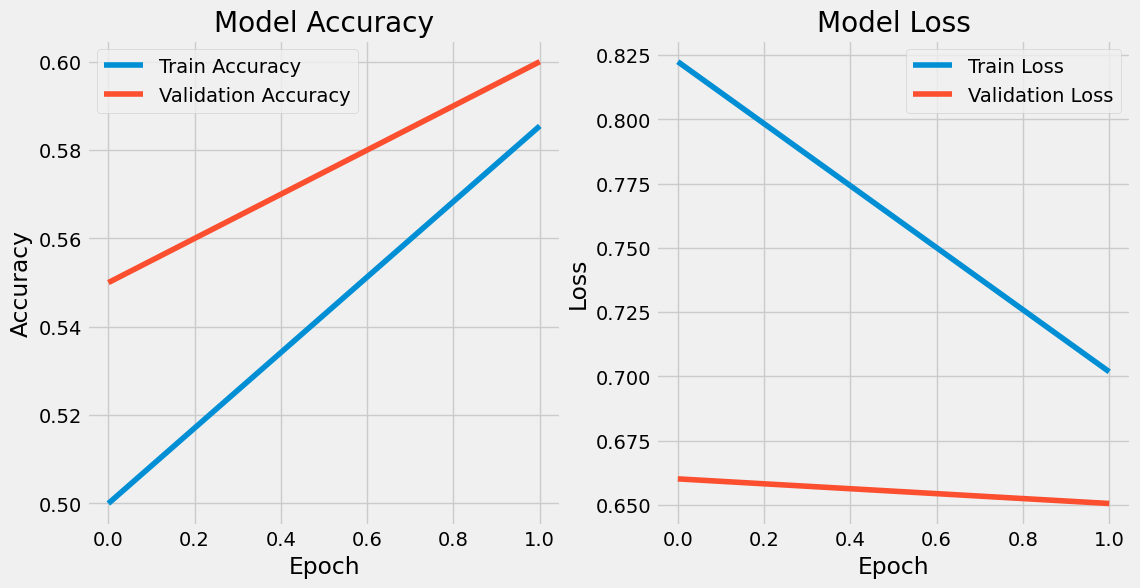

80/80 [==============================] - 52s 641ms/step - loss: 0.7018 - accuracy: 0.5854 - val_loss: 0.6506 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 3/100
80/80 [==============================] - ETA: 0s - loss: 0.6002 - accuracy: 0.6709
Epoch 3: val_loss improved from 0.65059 to 0.64474, saving model to /content/drive/My Drive/all files/second_model03.07.2024-1.h5


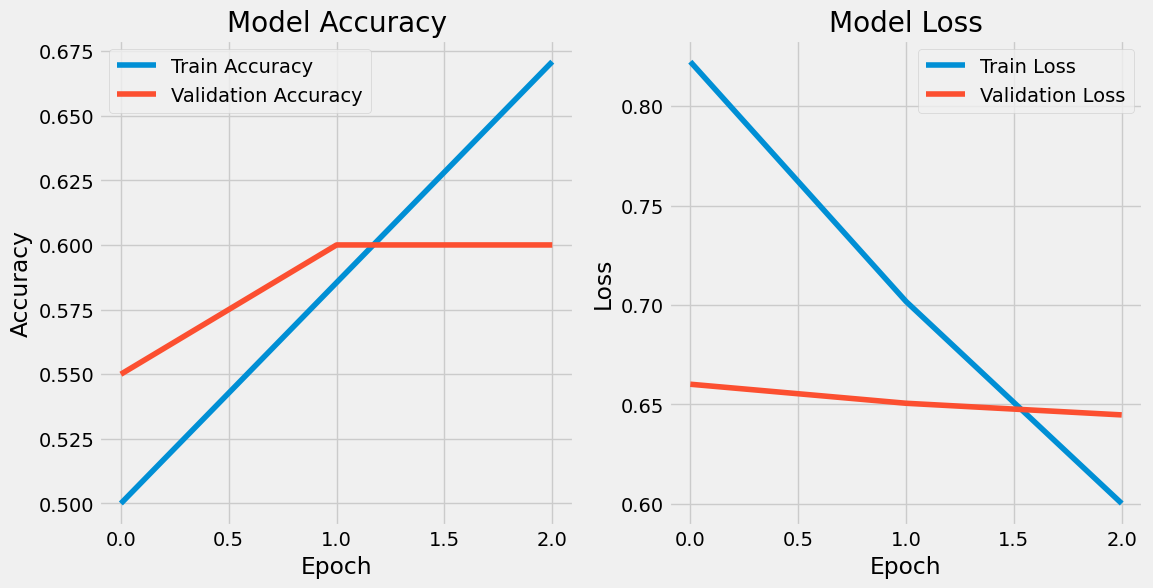

80/80 [==============================] - 54s 674ms/step - loss: 0.6002 - accuracy: 0.6709 - val_loss: 0.6447 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 4/100
80/80 [==============================] - ETA: 0s - loss: 0.5923 - accuracy: 0.6899
Epoch 4: val_loss did not improve from 0.64474


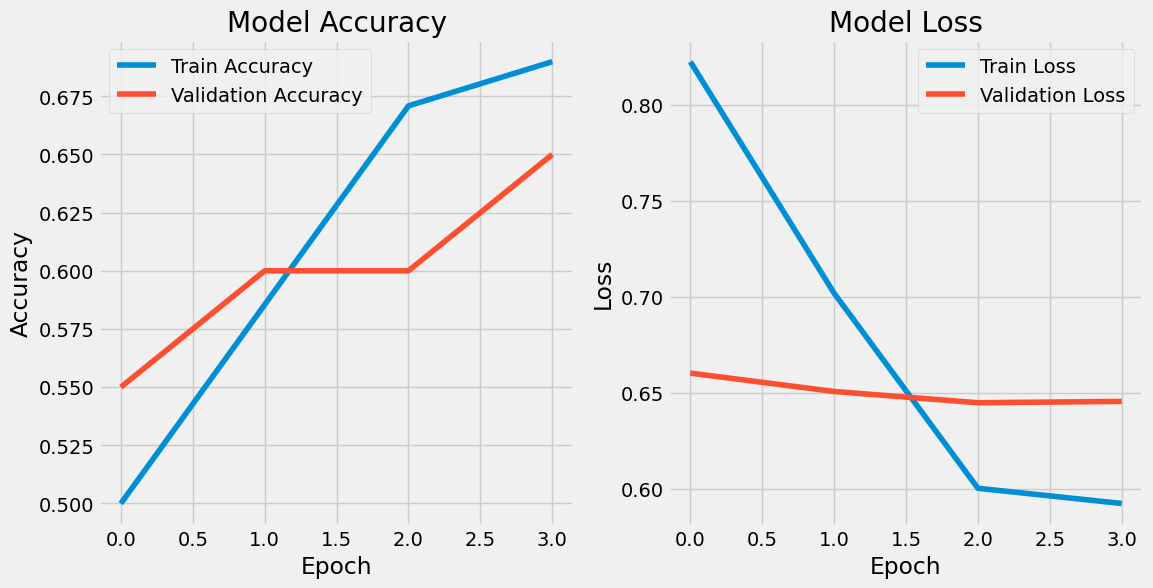

80/80 [==============================] - 51s 630ms/step - loss: 0.5923 - accuracy: 0.6899 - val_loss: 0.6454 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 5/100
80/80 [==============================] - ETA: 0s - loss: 0.5141 - accuracy: 0.7310
Epoch 5: val_loss did not improve from 0.64474


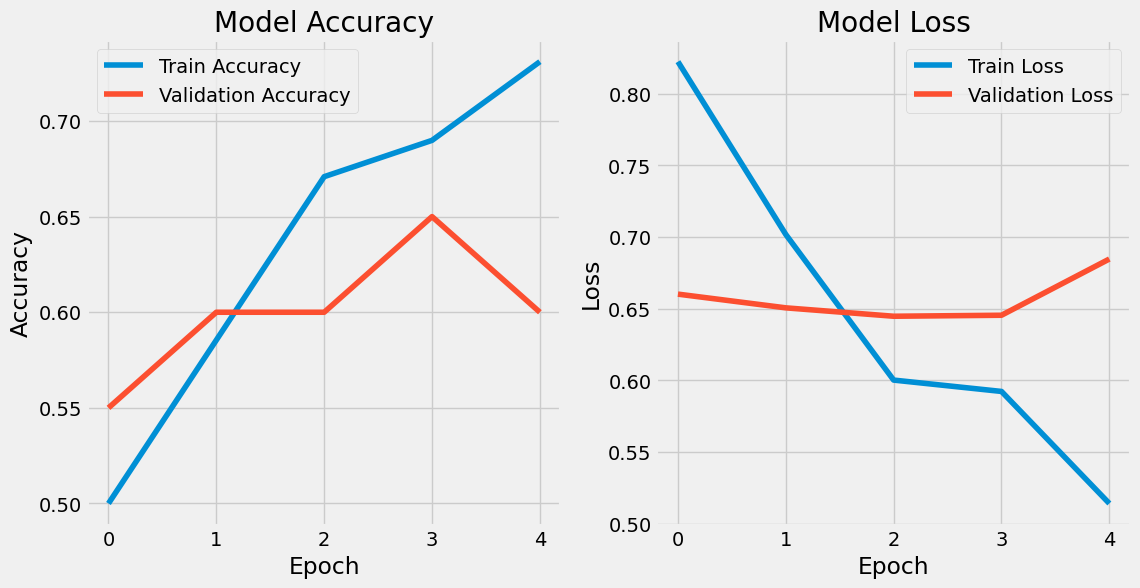

80/80 [==============================] - 50s 623ms/step - loss: 0.5141 - accuracy: 0.7310 - val_loss: 0.6847 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 6/100
80/80 [==============================] - ETA: 0s - loss: 0.5002 - accuracy: 0.7753
Epoch 6: val_loss improved from 0.64474 to 0.62601, saving model to /content/drive/My Drive/all files/second_model03.07.2024-1.h5


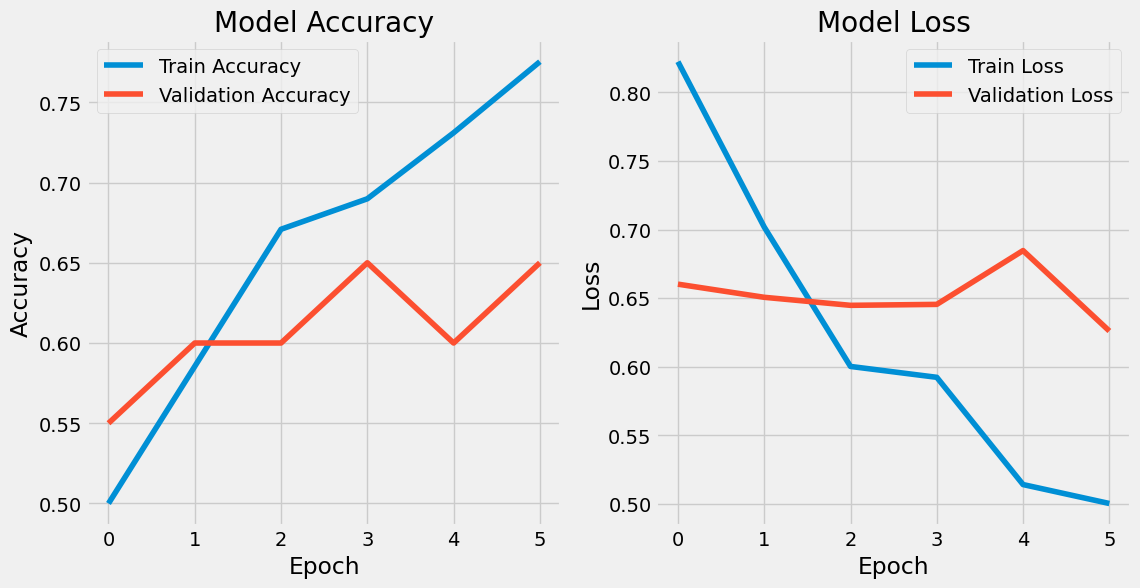

80/80 [==============================] - 52s 642ms/step - loss: 0.5002 - accuracy: 0.7753 - val_loss: 0.6260 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 7/100
80/80 [==============================] - ETA: 0s - loss: 0.4487 - accuracy: 0.7816
Epoch 7: val_loss did not improve from 0.62601


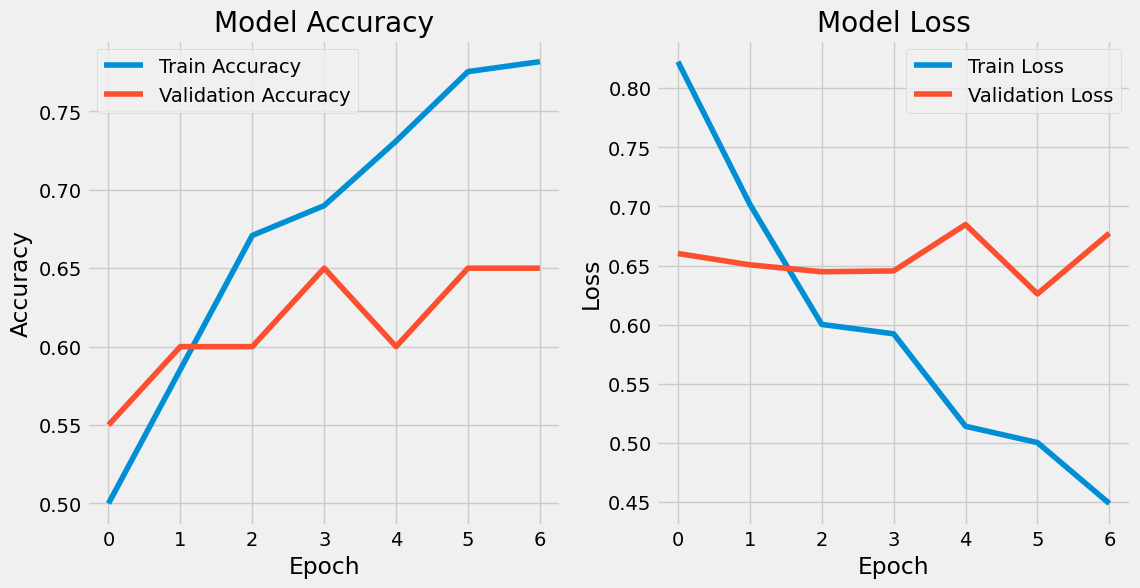

80/80 [==============================] - 51s 629ms/step - loss: 0.4487 - accuracy: 0.7816 - val_loss: 0.6773 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 8/100
80/80 [==============================] - ETA: 0s - loss: 0.4808 - accuracy: 0.7722
Epoch 8: val_loss did not improve from 0.62601


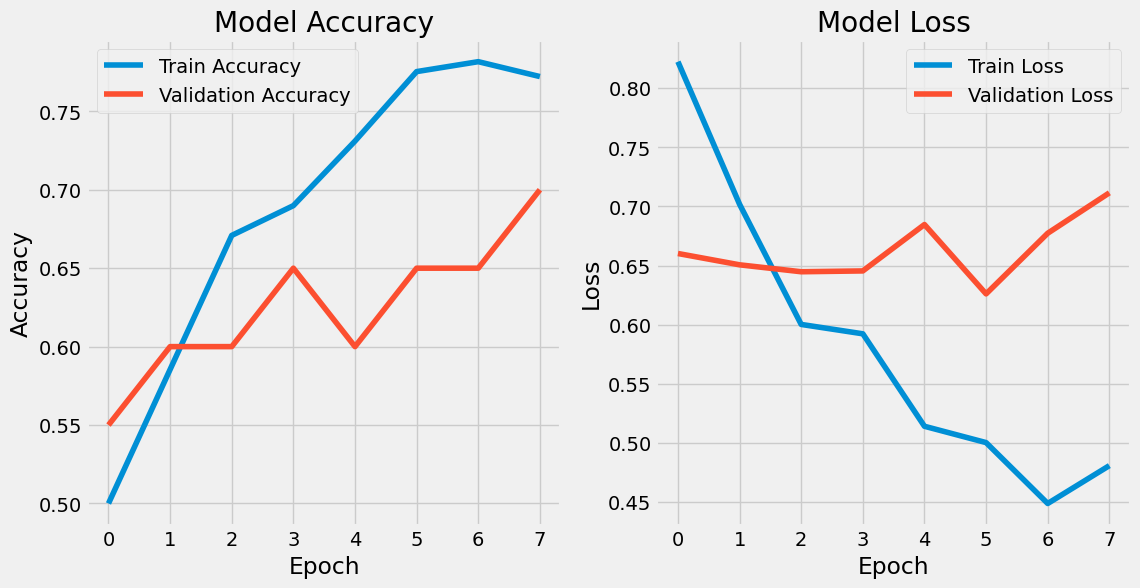

80/80 [==============================] - 50s 625ms/step - loss: 0.4808 - accuracy: 0.7722 - val_loss: 0.7115 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 9/100
80/80 [==============================] - ETA: 0s - loss: 0.4151 - accuracy: 0.8228
Epoch 9: val_loss improved from 0.62601 to 0.59652, saving model to /content/drive/My Drive/all files/second_model03.07.2024-1.h5


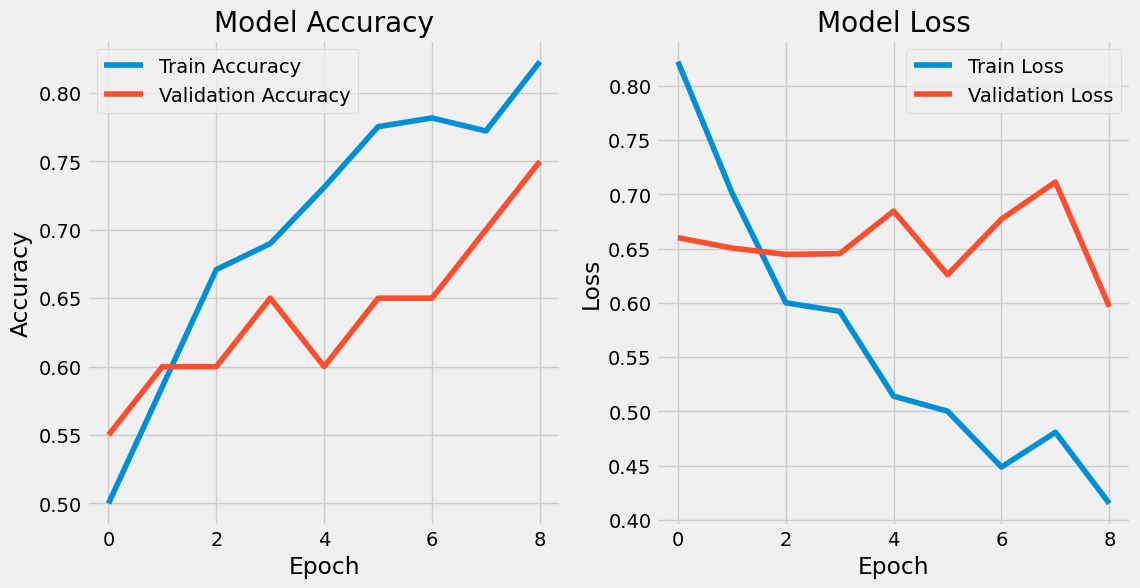

80/80 [==============================] - 53s 657ms/step - loss: 0.4151 - accuracy: 0.8228 - val_loss: 0.5965 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 10/100
80/80 [==============================] - ETA: 0s - loss: 0.3924 - accuracy: 0.8291
Epoch 10: val_loss did not improve from 0.59652


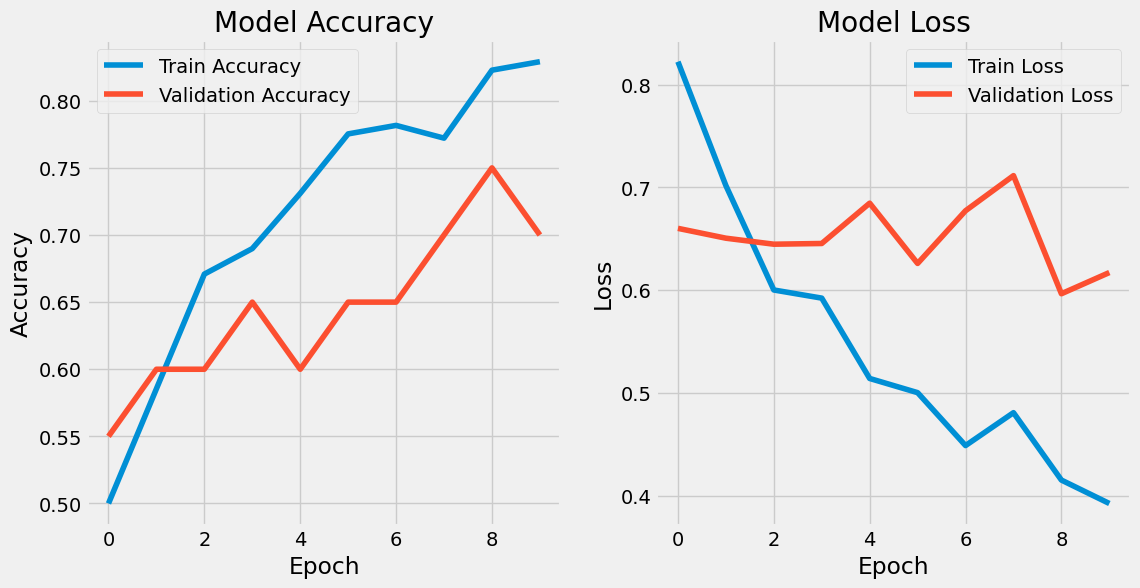

80/80 [==============================] - 51s 633ms/step - loss: 0.3924 - accuracy: 0.8291 - val_loss: 0.6172 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 11/100
80/80 [==============================] - ETA: 0s - loss: 0.3778 - accuracy: 0.8481
Epoch 11: val_loss did not improve from 0.59652


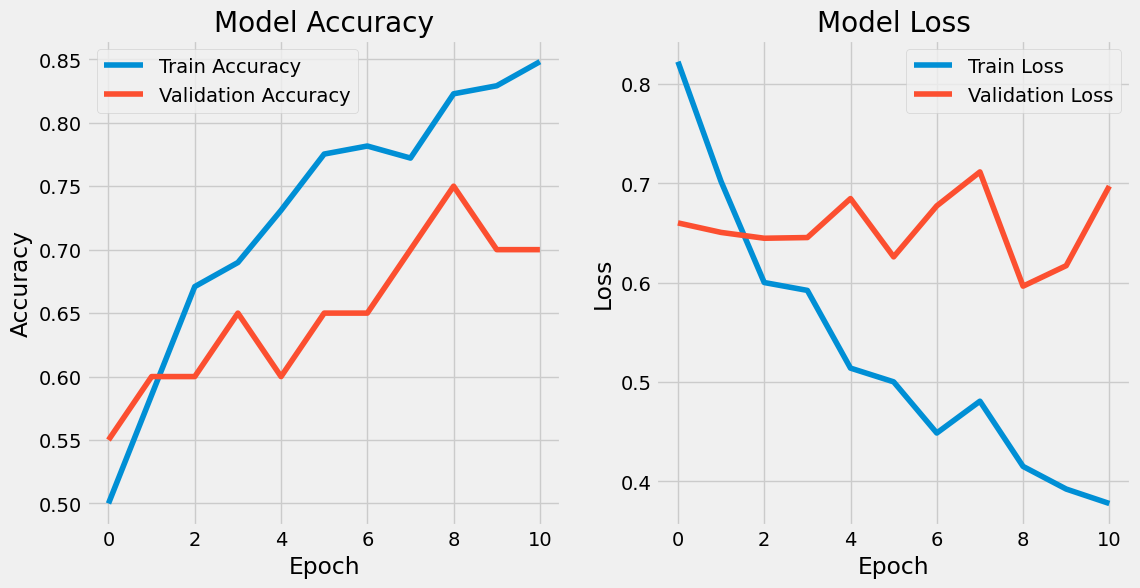

80/80 [==============================] - 51s 634ms/step - loss: 0.3778 - accuracy: 0.8481 - val_loss: 0.6972 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 12/100
80/80 [==============================] - ETA: 0s - loss: 0.3509 - accuracy: 0.8386
Epoch 12: val_loss did not improve from 0.59652


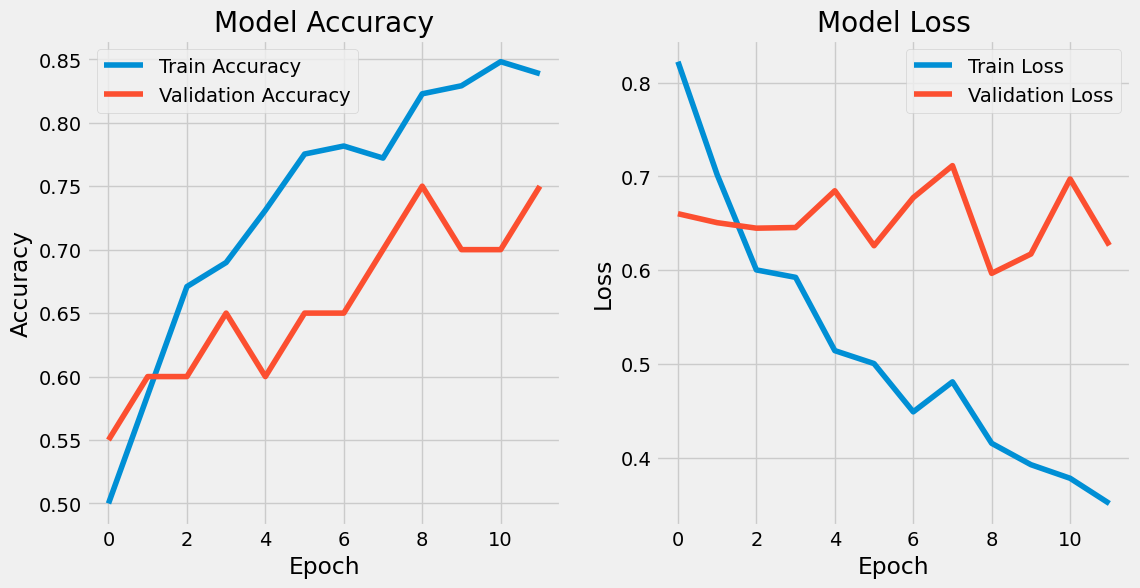

80/80 [==============================] - 51s 640ms/step - loss: 0.3509 - accuracy: 0.8386 - val_loss: 0.6264 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 13/100
80/80 [==============================] - ETA: 0s - loss: 0.3508 - accuracy: 0.8639
Epoch 13: val_loss did not improve from 0.59652


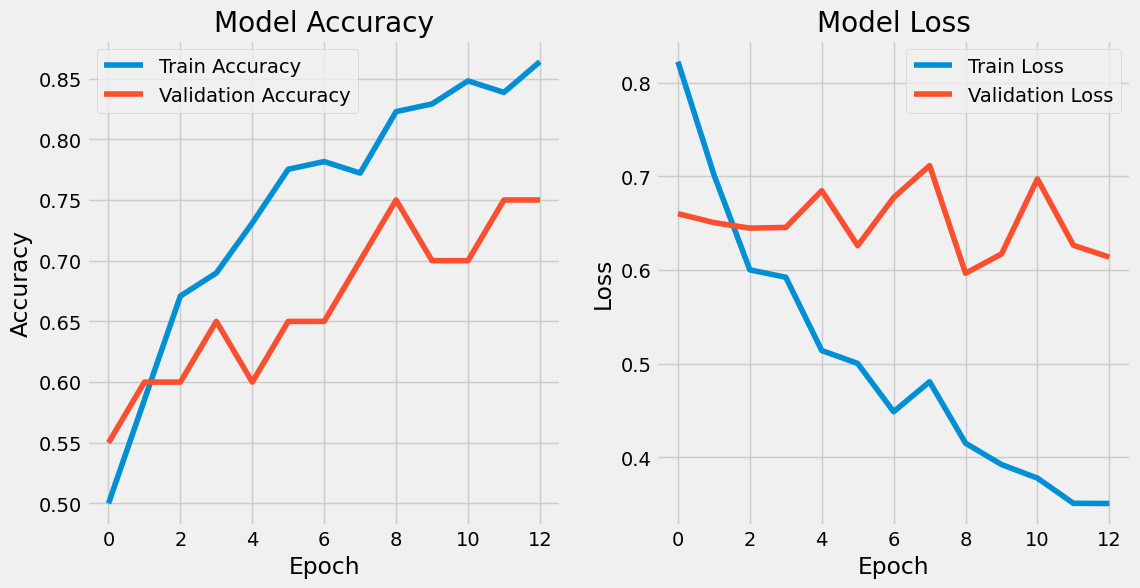

80/80 [==============================] - 50s 620ms/step - loss: 0.3508 - accuracy: 0.8639 - val_loss: 0.6137 - val_accuracy: 0.7500 - lr: 3.0000e-05
Epoch 14/100
80/80 [==============================] - ETA: 0s - loss: 0.3487 - accuracy: 0.8544
Epoch 14: val_loss did not improve from 0.59652


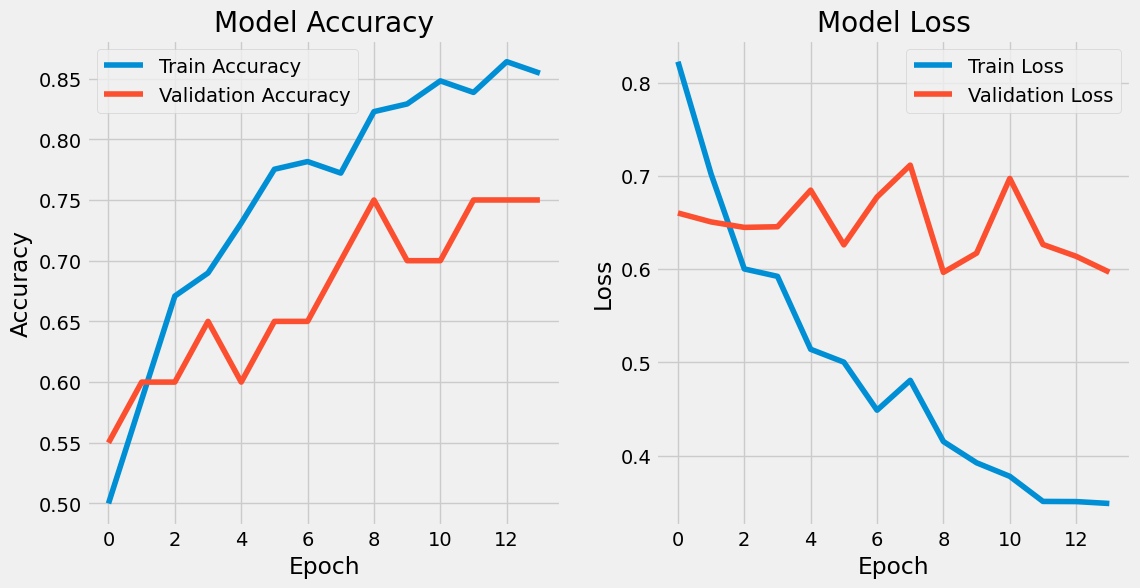

80/80 [==============================] - 52s 644ms/step - loss: 0.3487 - accuracy: 0.8544 - val_loss: 0.5967 - val_accuracy: 0.7500 - lr: 3.0000e-05
Epoch 15/100
80/80 [==============================] - ETA: 0s - loss: 0.3297 - accuracy: 0.8576
Epoch 15: val_loss did not improve from 0.59652


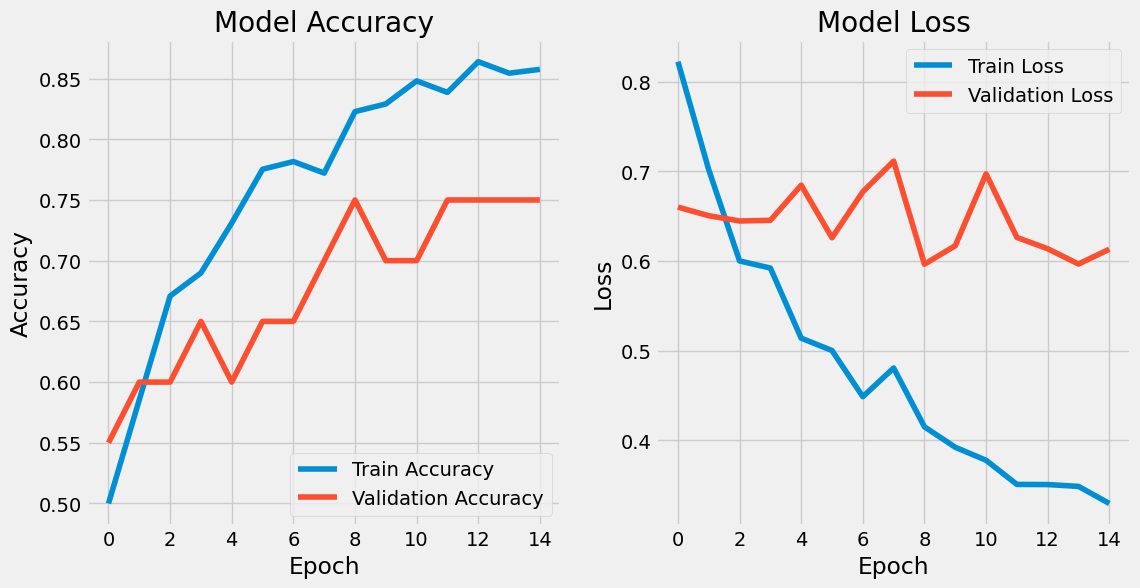

80/80 [==============================] - 51s 630ms/step - loss: 0.3297 - accuracy: 0.8576 - val_loss: 0.6132 - val_accuracy: 0.7500 - lr: 3.0000e-05
Epoch 16/100
80/80 [==============================] - ETA: 0s - loss: 0.3474 - accuracy: 0.8671
Epoch 16: val_loss did not improve from 0.59652


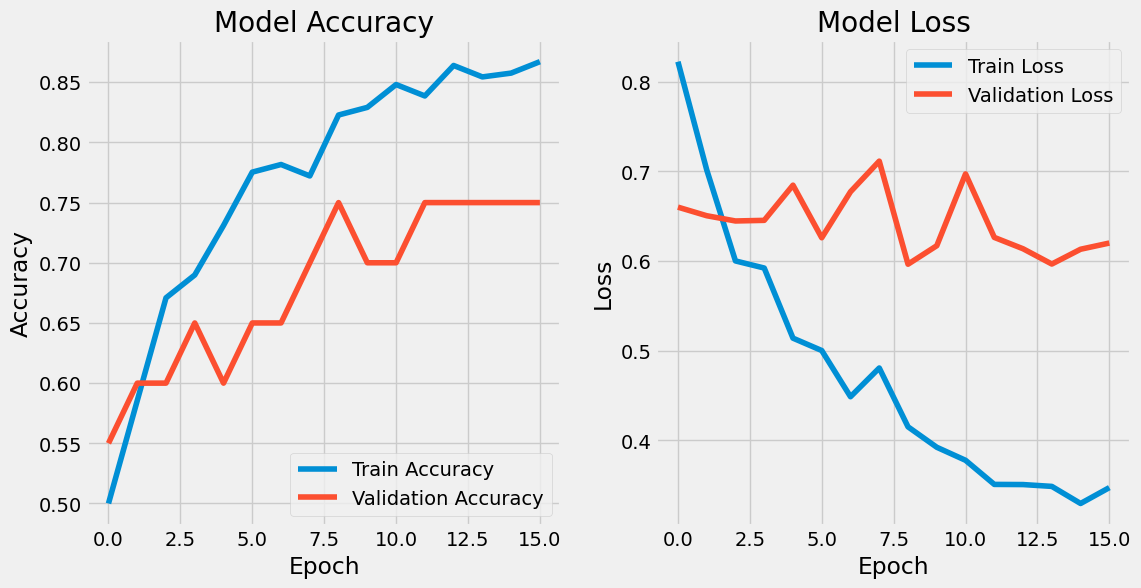

80/80 [==============================] - 53s 656ms/step - loss: 0.3474 - accuracy: 0.8671 - val_loss: 0.6201 - val_accuracy: 0.7500 - lr: 9.0000e-06
Epoch 17/100
80/80 [==============================] - ETA: 0s - loss: 0.3132 - accuracy: 0.8703
Epoch 17: val_loss did not improve from 0.59652


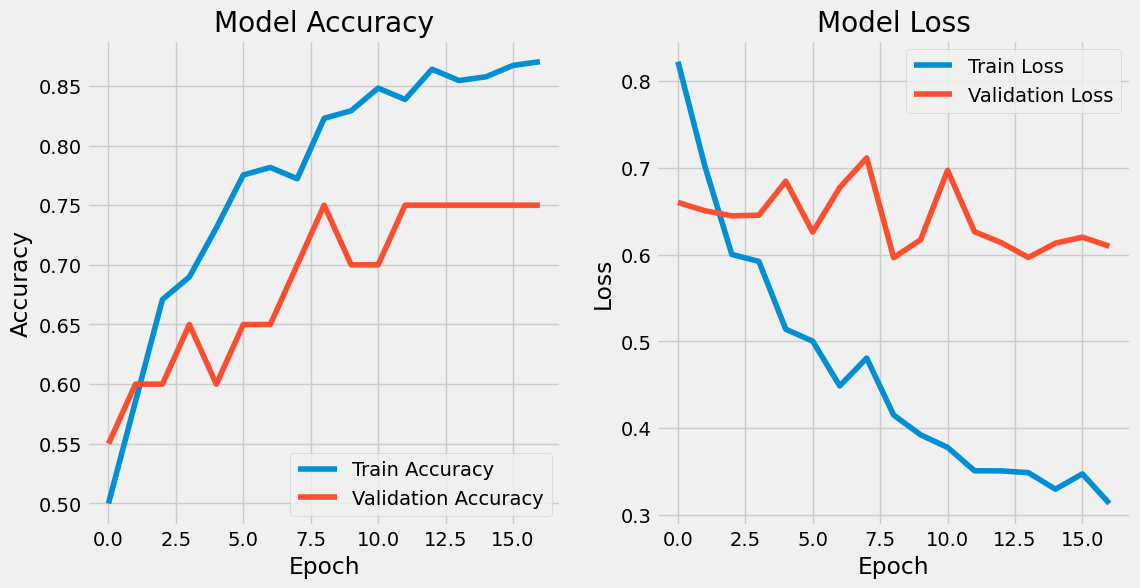

80/80 [==============================] - 51s 631ms/step - loss: 0.3132 - accuracy: 0.8703 - val_loss: 0.6097 - val_accuracy: 0.7500 - lr: 9.0000e-06
Epoch 18/100
80/80 [==============================] - ETA: 0s - loss: 0.3236 - accuracy: 0.8703
Epoch 18: val_loss did not improve from 0.59652


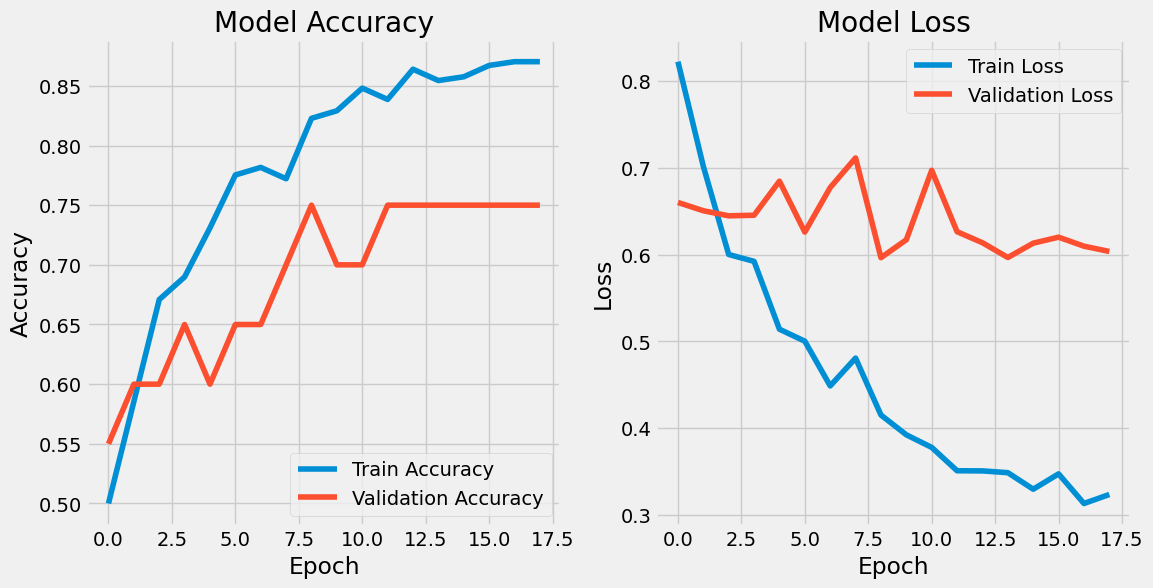

80/80 [==============================] - 52s 646ms/step - loss: 0.3236 - accuracy: 0.8703 - val_loss: 0.6037 - val_accuracy: 0.7500 - lr: 9.0000e-06
Epoch 19/100
80/80 [==============================] - ETA: 0s - loss: 0.3275 - accuracy: 0.8544
Epoch 19: val_loss did not improve from 0.59652


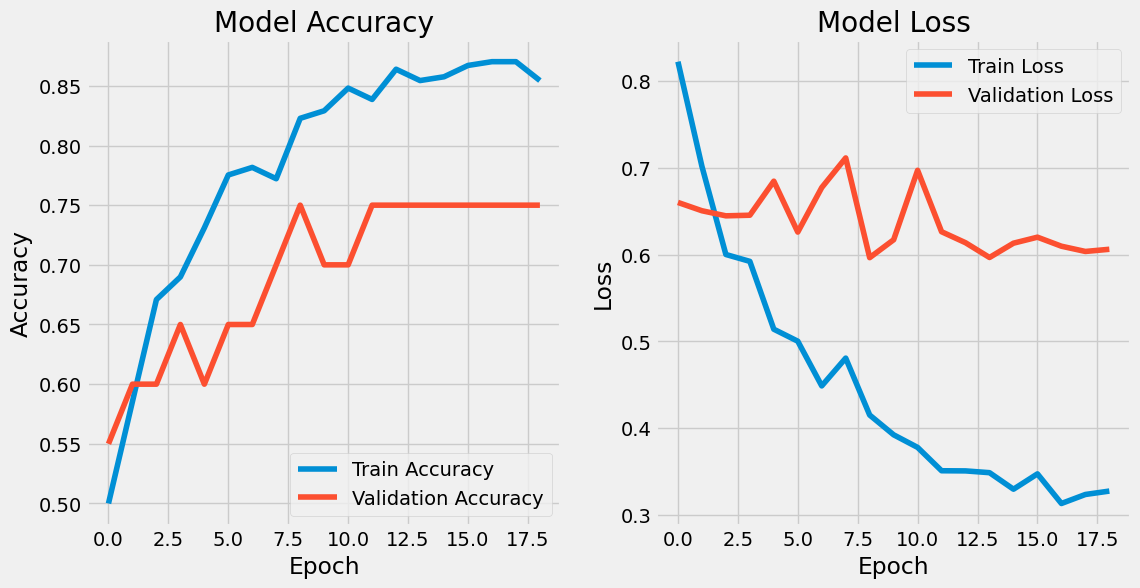

80/80 [==============================] - 51s 631ms/step - loss: 0.3275 - accuracy: 0.8544 - val_loss: 0.6062 - val_accuracy: 0.7500 - lr: 2.7000e-06
Epoch 19: early stopping


In [ ]:
second_history = second_model.fit(train_ds_final,
                    epochs=100,
                    validation_data = val_ds,
                    callbacks=callbacks,
                    verbose=1)
second_model.save('/content/drive/My Drive/all files/second__model03.07.2024-1.h5')  # Update the path as needed

In [32]:
with keras.utils.CustomObjectScope({'KerasLayer': hub.KerasLayer}):
  old_model = tf.keras.models.load_model('/content/drive/My Drive/all files/second_model03.07.2024-1.h5')
# Load the model from the specified path

# Print the model summary
old_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 50, 224, 224, 3   0         
                             )]                                  
                                                                 
 keras_layer_4 (KerasLayer)  (None, 600)               12909544  
                                                                 
 dense_12 (Dense)            (None, 128)               76928     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 32)                4128      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                           

## evaluation

## Test Frame Extraction

In [33]:
#test frame extraction and preprocessing
def new_extract_test_frames(video_path,label,resize=(224, 224), max_frames=50):
    video_path = video_path.decode("utf-8") if isinstance(video_path, bytes) else video_path
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = 7
    start_frame, end_frame = 0, total_frames
    frames = []
    empty_frame = np.zeros((resize[1], resize[0], 3))
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    while len(frames) < max_frames and cap.get(cv2.CAP_PROP_POS_FRAMES) <= end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        if (cap.get(cv2.CAP_PROP_POS_FRAMES - 1 - start_frame) % interval) == 0:
            frame = cv2.resize(frame, resize)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
            frame = frame.astype(np.float32) / 255.0
            frames.append(frame)

    cap.release()
    # Pad frames if fewer than max_frames were captured
    if len(frames) < max_frames:
      i = 0
      while len(frames) < max_frames:
        frames.append(frames[i])
        i+=1
    return np.array(frames,dtype=np.float32), int(label)

In [34]:
def new_preprocess_test_dataset(file_paths, labels, max_frames=50, resize=(224, 224)):
    def load_and_preprocess(video_path, label):
        video_segments, segment_labels = tf.numpy_function(
            new_extract_test_frames,
            [video_path, label, resize, max_frames],
            [tf.float32, tf.int64])  # Ensure correct data types

        num_channels = 3  # RGB channels
        video_segments.set_shape([max_frames, resize[1], resize[0], num_channels])
        segment_labels.set_shape([])  # Single label per video

        return video_segments, segment_labels

    path_ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = path_ds.map(lambda video_path, label: load_and_preprocess(video_path, label),
                          num_parallel_calls=tf.data.AUTOTUNE)

    return dataset.batch(1,drop_remainder=False).prefetch(tf.data.AUTOTUNE)


# Test loss and accuracy

In [35]:
# Assuming test_file_paths and test_labels are already defined
test_ds = new_preprocess_test_dataset(test_file_paths, y_test)
loss, accuracy = old_model.evaluate(test_ds)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

18/18 [==============================] - 49s 2s/step - loss: 0.4897 - accuracy: 0.8333
Test Loss: 0.48965010046958923
Test Accuracy: 0.8333333134651184


## Test Confusion Matrix

1/1 [==============================] - 0s 37ms/step


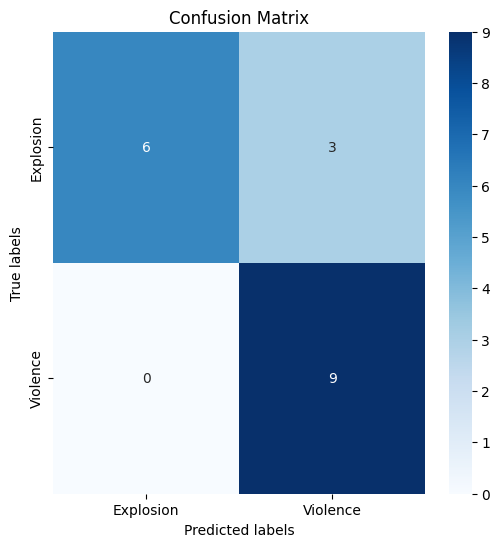

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the indices of the classes to check
specific_class_indices = [1]  # violence

# Define which label number corresponds to normal
explosion_label_index = 0  # Assume Explosion
y_prob = []
y_pred = []
y_true = []

# Iterate through the test dataset
for img_batch, label_batch in test_ds.unbatch().batch(1):
    prob = old_model.predict(img_batch)[0][0]
    y_prob.append(prob)

    # Get the prediction probabilities for the batch
    if prob > 0.5:
      y_pred.append("Violence")
    else:
      y_pred.append("Explosion")
    y_true.append('Explosion' if label_batch.numpy()[0] == explosion_label_index else 'Violence')

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['Explosion', 'Violence'])

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.set_xticklabels(['Explosion', 'Violence'])
ax.set_yticklabels(['Explosion', 'Violence'])
plt.show()


## Test ROC Curve

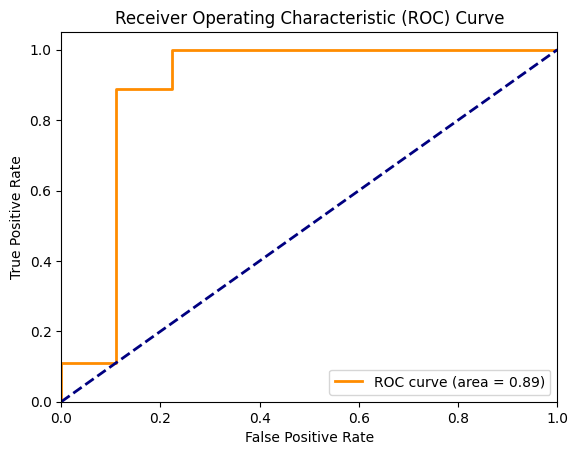

In [41]:
y_true_binary = [1 if label == 'Violence' else 0 for label in y_true]

# Compute ROC curve and ROC area for the "anomaly" class
fpr, tpr, _ = roc_curve(y_true_binary, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()